# **Tarefa 3 - Árvore de decisão**

#### **Dicas:**

- Tutorial para iniciantes em Python: https://www.datacamp.com/cheat-sheet/getting-started-with-python-cheat-sheet

- Documentação do pandas: https://colab.research.google.com/drive/1a4sbKG7jOJGn4oeonQPA8XjJm7OYgcdX

- Documentação do scikit-learn: https://scikit-learn.org/stable/

- Documentação do matplotlib: https://matplotlib.org/stable/index.html

- Documentação do seaborn: https://seaborn.pydata.org/tutorial.html

---
## **Dataset:**

Nesse dataset os dados estão relacionados com campanhas de marketing direto (telefonemas) de uma instituição bancária portuguesa. O objetivo da classificação é prever se o cliente irá subscrever um depósito a prazo (**feature y**).


---


**Colunas:**

1 - **age**

2 - **education**

3 - **default**: tem crédito em atraso?

4 - **balance**: saldo médio anual, em euros

5 - **housing**: tem empréstimo para habitação?

6 - **loan**: tem empréstimo pessoal?

7 - **contact**: tipo de comunicação de contato

8 - **day**: último dia de contato do mês

9 - **month**: último mês de contato do ano

10 - **campaign**: número de contatos realizados durante esta campanha e para este cliente

11 - **previous**: número de contatos realizados antes desta campanha e para este cliente

12 - **poutcome**: resultado da campanha de marketing anterior

13 - **y** - o cliente subscreveu um depósito a prazo?

## **Importe os pacotes**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix , recall_score, precision_score, f1_score


## **Crie os datasets**
### **Crie um DataFrame a partir do arquivo de dados disponibilizados no EaD**

**Dicas:**

* Certifique-se que os arquivos a serem lidos estão carregados na sua sessão do Colab, ou em um drive previamente montado, e ajuste o comando para incluir todo o caminho até cada um dos arquivos a serem lidos.

In [43]:
df = pd.read_csv("bank.csv")
print(df.head())
print(df.education.value_counts())
print(df.month.value_counts())
print(df.contact.unique())
print(df.poutcome.value_counts())
print(df.y.value_counts())

df.describe()

   age  education default  balance housing loan   contact  day month  \
0   23  secondary      no      567     yes  yes  cellular   15   may   
1   35  secondary      no        0     yes   no  cellular   17   apr   
2   42  secondary      no      400     yes   no  cellular    3   feb   
3   35    primary      no      793     yes   no  cellular   17   apr   
4   45  secondary      no     1723      no   no  cellular    1   jun   

   campaign  previous poutcome    y  
0         1         0    other   no  
1         1         0    other   no  
2         5         6  failure   no  
3         1         0    other   no  
4         2         0    other  yes  
education
secondary    3967
tertiary     3055
primary      1012
unknown       356
Name: count, dtype: int64
month
aug    1429
jul    1393
may    1321
apr     891
nov     859
feb     736
jun     405
oct     363
jan     304
sep     301
mar     271
dec     117
Name: count, dtype: int64
['cellular' 'telephone']
poutcome
other      6181
failu

,age,balance,day,campaign,previous
count,8390.000000,8390.000000,8390.000000,8390.000000,8390.000000
mean,41.540167,1639.136949,15.557688,2.413468,1.050894
std,12.551213,3388.213746,8.389036,2.413275,2.510706
min,18.000000,-3058.000000,1.000000,1.000000,0.000000
25%,32.000000,139.000000,8.000000,1.000000,0.000000
50%,39.000000,592.000000,15.000000,2.000000,0.000000
75%,50.000000,1853.000000,22.000000,3.000000,1.000000
max,95.000000,81204.000000,31.000000,43.000000,58.000000


# **Pré-processamento**

Utilize o conhecimento adquirido nos exercícios anteriores para realizar o pré-processamento desta base de dados, incluindo normalização, tratamento de features categóricas e manipulação de valores nulos.

In [44]:
def pre_process(df):
    # treating outliers
    for column in ['age', 'balance', 'day', 'campaign', 'previous']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[column] < (Q3 + 1.5 * IQR)) & (df[column] > (Q1 - 1.5 * IQR))]


    df[df['y'] == 'no']['education'].value_counts() # it's the same for both
    df.loc[df['education'] == 'unknown', 'education'] = 'secondary'

    oe_education = OrdinalEncoder(categories = [['primary', 'secondary', 'tertiary']])
    oe_month = OrdinalEncoder(categories = [['may', 'apr', 'feb', 'jun', 'aug', 'jul', 'nov', 'sep', 'oct', 'jan', 'dec', 'mar']])

    df['education'] = oe_education.fit_transform(df[['education']])
    df['month'] = oe_month.fit_transform(df[['month']])

    le_default = LabelEncoder()
    le_housing = LabelEncoder()
    le_loan = LabelEncoder()
    le_contact = LabelEncoder() # result of using OneHotEncoder would be the same, as there are only two possible values
    le_y = LabelEncoder()

    df['default'] = le_default.fit_transform(df['default'])
    df['housing'] = le_default.fit_transform(df['housing'])
    df['loan'] = le_default.fit_transform(df['loan'])
    df['contact'] = le_contact.fit_transform(df['contact'])
    df['y'] = le_y.fit_transform(df['y'])

    ohe = OneHotEncoder(sparse_output=False)
    poutcome = ohe.fit_transform(df[['poutcome']])
    df_poutcome = pd.DataFrame(poutcome, columns=ohe.get_feature_names_out(['poutcome']))
    df.drop(columns=['poutcome'], axis = 1, inplace = True)
    df.reset_index(drop=True, inplace=True)
    df_poutcome.reset_index(drop=True, inplace=True)
    df = pd.concat([df, df_poutcome], axis = 1)

    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

df = pre_process(df)
df.head(10)

,age,education,default,balance,housing,loan,contact,day,month,campaign,previous,y,poutcome_failure,poutcome_other,poutcome_success
0,0.086207,0.5,0.0,0.399937,1.0,1.0,0.0,0.466667,0.000000,0.00,0.0,0.0,0.0,1.0,0.0
1,0.293103,0.5,0.0,0.310378,1.0,0.0,0.0,0.533333,0.090909,0.00,0.0,0.0,0.0,1.0,0.0
2,0.293103,0.0,0.0,0.435634,1.0,0.0,0.0,0.533333,0.090909,0.00,0.0,0.0,0.0,1.0,0.0
3,0.465517,0.5,0.0,0.582530,0.0,0.0,0.0,0.000000,0.272727,0.25,0.0,1.0,0.0,1.0,0.0
4,0.637931,1.0,0.0,0.361396,1.0,1.0,0.0,0.400000,0.000000,0.00,0.0,0.0,0.0,1.0,0.0
5,0.413793,0.5,0.0,0.344969,1.0,1.0,0.0,0.200000,0.363636,0.50,0.0,0.0,0.0,1.0,0.0
6,0.103448,0.5,0.0,0.336756,0.0,1.0,0.0,0.800000,0.000000,0.00,1.0,1.0,0.0,0.0,1.0
7,0.500000,0.5,0.0,0.352393,0.0,0.0,0.0,0.600000,0.363636,0.00,0.0,0.0,0.0,1.0,0.0
8,0.517241,0.5,0.0,0.348918,1.0,1.0,0.0,0.033333,0.181818,0.00,0.0,0.0,0.0,1.0,0.0
9,0.724138,1.0,0.0,0.714263,1.0,0.0,0.0,0.033333,0.181818,0.00,0.0,1.0,0.0,1.0,0.0


# **Criação de Conjuntos de Treinamento, Teste e Validação**

Divida os dados em conjuntos de treino, validação e teste. Para isso, selecione aleatoriamente 70% dos registros, sem reposição, para o conjunto de treinamento. Os 30% restantes deverão ser divididos igualmente entre os conjuntos de validação e teste.

Dicas:
- Fixe a semente de geração de dados aleatórios, utilize o comando `np.random.seed(escolha um número)`, antes de executar qualquer célula de comando que possa variar de valor resultante toda vez que for executada.

- Para fazer a divisão de treino, validação, teste use a função `train_test_split()`

In [45]:
np.random.seed(42)
X = df.drop('y', axis=1)
y = df['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# **Treine e Teste o Modelo de Árvore de Decisão**

Treinar três versões diferentes do modelo de Árvore de Decisão utilizando valores variados para a sua profundidade.

**Dica:**

- Busque pela função `DecisionTreeClassifier(max_depth=?)` da biblioteca scikitlearn

In [46]:
depths = [3, 6, 9]
metrics = {}
trees = []

for i, n in enumerate(depths):
    trees.append({'model' : DecisionTreeClassifier(max_depth=n)})

    trees[i]['model'].fit(X_train, y_train)
    y_val_pred = trees[i]['model'].predict(X_val)
    trees[i]['pred'] = y_val_pred


# **Escolha e Avaliação do Modelo**

Neste momento, é importante avaliar cada um dos modelos gerados utilizando o **dataset de validação**. Apresente a matriz de confusão, bem como as métricas de acurácia, precisão, recall e F1-score para cada modelo. Após avaliá-los **escolha o melhor modelo**

**Dica:**

- Você pode usar a função `confusion_matrix(_, _)` da biblioteca `scikitlearn.metrics`
- Para calcular as métricas do modelo busque pelas funções `accuracy_score()`, `recall_score()`, `precision_score()`, `f1_score()`

Results for Decision Tree with depth = 3:
Accuracy: 63.4009%
Precision: 69.4989%
Recall: 63.2937%
F1 Score: 66.2513%


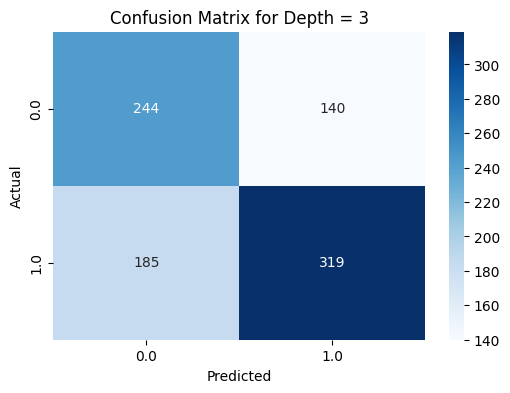

Results for Decision Tree with depth = 6:
Accuracy: 64.7523%
Precision: 74.8052%
Recall: 57.1429%
F1 Score: 64.7919%


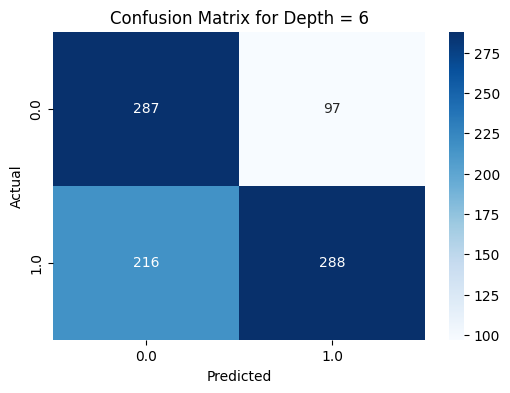

Results for Decision Tree with depth = 9:
Accuracy: 65.7658%
Precision: 77.3224%
Recall: 56.1508%
F1 Score: 65.0575%


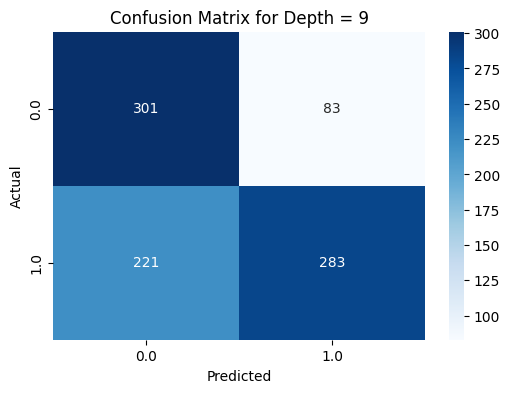

The best model is the Decision Tree with depth = 3, based on F1-score.


In [6]:
confusion_matrices = {}
metrics = {}

# Evaluate models on validation dataset
for i, depth in enumerate(depths):
    # Get the model trained with the current depth
    tree = trees[i]['model']  # Access the 'model' key from the dictionary
    
    # Make predictions on the validation dataset
    y_val_pred = tree.predict(X_val)
    
    # Get the correct labels for your dataset (e.g., 'yes', 'no' or [0, 1])
    unique_labels = np.unique(y_val)
    
    # Compute confusion matrix with the actual labels
    cm = confusion_matrix(y_val, y_val_pred, labels=unique_labels)
    confusion_matrices[depth] = cm
    
    # Calculate accuracy, precision, recall, F1-score (adjust pos_label to match your positive class)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, pos_label=unique_labels[1])  # Adjust as needed
    recall = recall_score(y_val, y_val_pred, pos_label=unique_labels[1])        # Adjust as needed
    f1 = f1_score(y_val, y_val_pred, pos_label=unique_labels[1])                # Adjust as needed
    
    # Store the metrics for each depth
    metrics[depth] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Display the results
    print(f"Results for Decision Tree with depth = {depth}:")
    print(f"Accuracy: {accuracy:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1 Score: {f1:.4%}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(f'Confusion Matrix for Depth = {depth}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Choose the best model based on F1-score (or any other metric)
best_depth = max(metrics, key=lambda x: metrics[x]['f1'])
best_model = trees[depths.index(best_depth)]['model']

print(f"The best model is the Decision Tree with depth = {best_depth}, based on F1-score.")

# **Feature Importance**

Utilizando o melhor modelo gere o gráfico de importância das features para o modelo que obteve o melhor desempenho nos dados de validação. Em seguida, **remova as** **cinco** **features com menor importância e treine o modelo com o conjunto de treino novamente.**

**Dica**

- Utilize o método `.feature_importances_` da biblioteca `sklearn` para obter os valores de importância de cada feature.



In [7]:
best_model = trees[1]['model']
feature_relevance = pd.DataFrame({'feature':df.columns.drop('y'),'value':best_model.feature_importances_})
feature_relevance.sort_values('value',ascending=False)

,feature,value
13,poutcome_success,0.263618
8,month,0.231133
3,balance,0.162817
7,day,0.151596
4,housing,0.134155
0,age,0.031324
5,loan,0.009759
10,previous,0.008029
2,default,0.004140
9,campaign,0.002128


In [8]:
columns_of_least_importance = ['poutcome_other','poutcome_failure','contact','education','campaign']


X_train.drop(columns=columns_of_least_importance)
X_val.drop(columns=columns_of_least_importance)
X_test.drop(columns=columns_of_least_importance)

for tree in trees:
    tree['model'].fit(X_train,y_train)
    tree['pred'] = tree['model'].predict(X_val)

# **Avaliação do Novo Modelo**

Com as cinco features removidas, avalie novamente o modelo de árvore de decisão escolhido, utilizando apenas o **conjunto de validação**.

In [9]:
for i, tree in enumerate(trees):
    pred = tree['pred']
    accuracy = accuracy_score(y_val, pred)
    precision = precision_score(y_val, pred)
    recall = recall_score(y_val, pred)
    f1 = f1_score(y_val, pred)

    print(f"Results for Decision Tree with depth = {(i+1)*3}:")
    print(f"Accuracy: {accuracy:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1 Score: {f1:.4%}\n")

Results for Decision Tree with depth = 3:
Accuracy: 63.4009%
Precision: 69.4989%
Recall: 63.2937%
F1 Score: 66.2513%

Results for Decision Tree with depth = 6:
Accuracy: 64.8649%
Precision: 75.0000%
Recall: 57.1429%
F1 Score: 64.8649%

Results for Decision Tree with depth = 9:
Accuracy: 66.3288%
Precision: 77.6280%
Recall: 57.1429%
F1 Score: 65.8286%



# **Plotar a árvore do melhor modelo**

Gere a visualização da Árvore de Decisão do novo modelo

**Dica:**

- Use a função `plot_tree()` da biblioteca `sklearn`

- Para tornar a visualização mais clara e facilitar a interpretação dos resultados, ajuste o parâmetro max_depth em `plot_tree(max_depth=?)`, limitando a profundidade da árvore exibida e destacando os nós mais significativos.

# **Criação de Exemplos Fictícios**

Observe a estrutura da árvore de decisão treinada e crie dois exemplos fictícios, um para cada possível valor do target. Para cada exemplo, descreva detalhadamente o caminho que ele seguirá na árvore, ou seja, a sequência de nós que serão percorridos até chegar à folha correspondente.

In [10]:
test_df = pd.DataFrame(data={
    'age': [42, 35], 
    'education': ['tertiary', 'primary'], 
    'default': ['no', 'yes'], 
    'balance': [1568, 890], 
    'housing': ['yes', 'yes'],
    'loan': ['no', 'no'], 
    'contact': ['cellular', 'telephone'], 
    'day': [29, 3], 
    'month': ['may', 'jun'], 
    'campaign': [2, 1], 
    'previous': [0, 5], 
    'poutcome': ['other', 'success']
})
test_df = pre_process(test_df)
test_df.head()

NameError: name 'pre_process' is not defined

# **Inferência e Verificação**

Realize uma inferência utilizando esses dois exemplos fictícios no modelo treinado. Verifique se os resultados obtidos na inferência correspondem aos valores do target que você imaginou ao criar os exemplos.

# **Escolha do melhor modelo**

Selecione o melhor modelo até agora com base no desempenho no conjunto de validação durante a etapa de avaliação e faça uma avaliação final do desempenho utilizando o **conjunto de** **teste**.

In [ ]:
# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate metrics for the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Performance on the Test Set:")
print(f"Test Accuracy: {test_accuracy:.4%}")
print(f"Test Precision: {test_precision:.4%}")
print(f"Test Recall: {test_recall:.4%}")
print(f"Test F1 Score: {test_f1:.4%}")

# **Mostre uma análise comparativa entre validação e teste para o modelo escolhido**

**Observação:** Se houver uma discrepância muito grande nos resultados, algo pode estar errado, verifique seu treinamento e avaliação do modelo.